# Loading Image Data
In the previous notebooks, we used PyTorch's datasets which were nicely formatted for use out of the box. In this notebook we will learn how to store our own custom images and load them for use.

In [1]:
# add path to my data_science convenience classes location
import sys
sys.path.append('C:\\Users\\WNeill\\PycharmProjects\\data_science')

import torch
from torchvision import datasets, transforms, models
import neural_networks.based_sequential as bs

import matplotlib.pyplot as plt

Define some transforms for both training and test sets. Random transformations should be applied to the training set to help a network better generalize. The validation set should be resized, cropped and normalized the same as the training data. However, the random augmentations should not be added to the validation set. 

In [2]:
# Training set
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                    [0.5, 0.5, 0.5])
                               ])

random_ts =  transforms.RandomApply([transforms.RandomHorizontalFlip(),
                                     transforms.RandomGrayscale(),
                                     transforms.RandomPerspective(),
                                     transforms.RandomVerticalFlip()])

augment = transforms.Compose([random_ts, transform])

In [3]:
trainset = datasets.ImageFolder('data/Cat_Dog_data/train/', transform=augment)
testset = datasets.ImageFolder('data/Cat_Dog_data/test/', transform=transform)

In [4]:
trainload = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [9]:
images, labels = iter(trainload).next()
image = images[0]
image.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


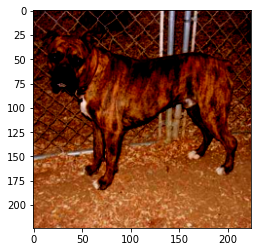

In [10]:
image = image.permute(1, 2, 0)
plt.imshow(image.numpy())

# Transfer Learning
A fully connected network with random initialized weights is probably not up to the task of classifying these dog and cat images. Instead, we will use pre-trained networks that have done the majority of the training we need already. We'll then refine these pre-trained networks to our specific use. 

In [11]:
model = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\WNeill/.cache\torch\checkpoints\densenet121-a639ec97.pth


We need to use the same normalization parameters as when the models were trained.

In [13]:
# Standard transforms
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

# Training specific transforms
random_ts =  transforms.RandomApply([transforms.RandomHorizontalFlip(),
                                     transforms.RandomGrayscale(),
                                     transforms.RandomPerspective(),
                                     transforms.RandomVerticalFlip()])

# Data augmentation                                
augment = transforms.Compose([random_ts, 
                              transform,
                              transforms.Normalize([0.485, 0.456, 0.406],
                                                   [0.229, 0.224, 0.225])])